filter data entry csv for relevant classes

In [ ]:
import pandas as pd
import os

# Paths
csv_path = "Data_Entry_2017.csv"
image_dir = "chest_xray_full/images"


# Load and clean
df = pd.read_csv(csv_path)
available_images = set(os.listdir(image_dir))
df = df[df['Image Index'].isin(available_images)]

df['Finding Labels'] = df['Finding Labels'].str.split('|')
df['num_labels'] = df['Finding Labels'].apply(len)
df = df[df['num_labels'] == 1]
df['Label'] = df['Finding Labels'].str[0]

# Top 3 classes (excluding "No Finding")
top6_labels = df['Label'].value_counts().drop("No Finding", errors='ignore').nlargest(3).index.tolist()

# Keep all rows with those 3 classes
df_top6 = df[df['Label'].isin(top6_labels)]
df_subset = df[df['Label'].isin(top6_labels)].reset_index(drop=True)


print("Final subset class distribution:")
print(df_subset['Label'].value_counts())


Final subset class distribution:
Label
Infiltration    9547
Atelectasis     4215
Effusion        3955
Name: count, dtype: int64


get weights to address class imbalance

In [ ]:
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_subset['Label']),
    y=df_subset['Label']
)

weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


create dataset class

In [ ]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
import torch

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.copy()
        self.image_dir = image_dir
        self.transform = transform

        # Encode string labels
        self.label_encoder = LabelEncoder()
        self.data['label_idx'] = self.label_encoder.fit_transform(self.data['Label'])
        self.class_names = list(self.label_encoder.classes_)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['Image Index'])
        label = torch.tensor(row['label_idx'], dtype=torch.long)

        # load and transform image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


set data loaders, split dataset

In [ ]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

image_dir = "chest_xray_full/images"
dataset = ChestXrayDataset(dataframe=df_subset, image_dir=image_dir, transform=transform)

# Split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

# Confirm sizes
print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")
print(f"Classes: {dataset.class_names}")


Train: 12401 | Val: 2657 | Test: 2659
Classes: ['Atelectasis', 'Effusion', 'Infiltration']


show class-weight mapping

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# use same label list for weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_subset['Label']),
    y=df_subset['Label']
)

weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# label-weight mapping
print("Class Weights:")
for idx, (label, weight) in enumerate(zip(dataset.class_names, weights.cpu().numpy())):
    print(f"Class {idx}: {label:<20} → Weight: {weight:.4f}")


Class Weights:
Class 0: Atelectasis          → Weight: 1.4011
Class 1: Effusion             → Weight: 1.4932
Class 2: Infiltration         → Weight: 0.6186


train efficient net CNN model

Using device: CPU


Epoch 1 [Train]:   0%|          | 0/388 [00:00<?, ?it/s]

C:\Users\Deeks\AppData\Local\Temp\ipykernel_34420\1489869507.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(label, dtype=torch.long)


Epoch 1 [Val]:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 0.8392, Acc: 0.6257 | Val Loss: 0.7530, Acc: 0.6680


Epoch 2 [Train]:   0%|          | 0/388 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 0.7247, Acc: 0.6907 | Val Loss: 0.7252, Acc: 0.6842


Epoch 3 [Train]:   0%|          | 0/388 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 0.6702, Acc: 0.7197 | Val Loss: 0.7209, Acc: 0.6918


Epoch 4 [Train]:   0%|          | 0/388 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 0.6370, Acc: 0.7324 | Val Loss: 0.7146, Acc: 0.6906


Epoch 5 [Train]:   0%|          | 0/388 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 0.6063, Acc: 0.7465 | Val Loss: 0.7349, Acc: 0.6948


Epoch 6 [Train]:   0%|          | 0/388 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 0.5622, Acc: 0.7690 | Val Loss: 0.7357, Acc: 0.7076


Epoch 7 [Train]:   0%|          | 0/388 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 0.5261, Acc: 0.7845 | Val Loss: 0.7827, Acc: 0.6887
⏹️ Early stopping at epoch 7


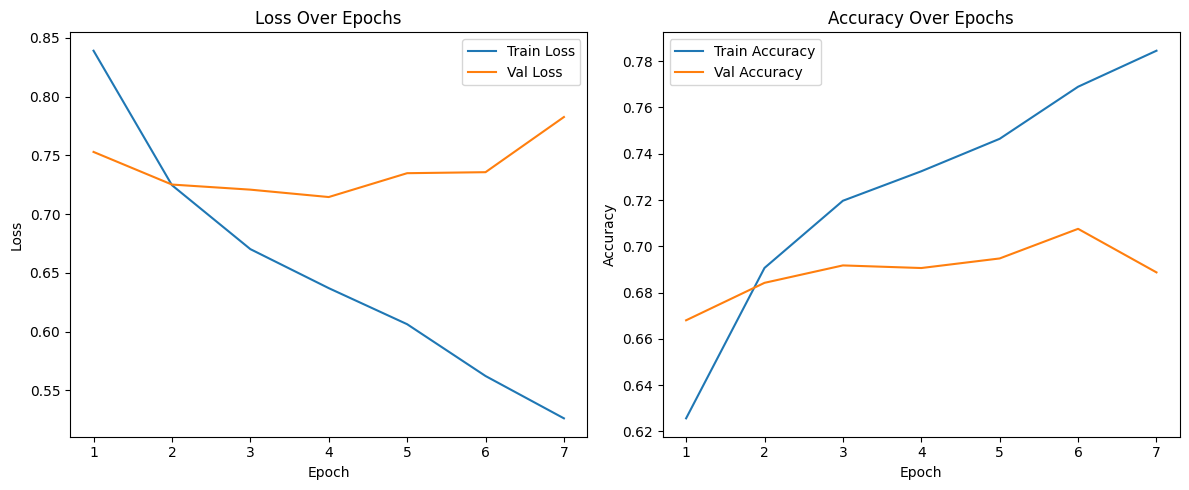


✅ Final Test Loss: 0.7113 | Accuracy: 0.6991

🔍 Classification Report:
              precision    recall  f1-score   support

 Atelectasis       0.58      0.56      0.57       627
    Effusion       0.66      0.63      0.64       626
Infiltration       0.76      0.80      0.78      1406

    accuracy                           0.70      2659
   macro avg       0.67      0.66      0.66      2659
weighted avg       0.70      0.70      0.70      2659



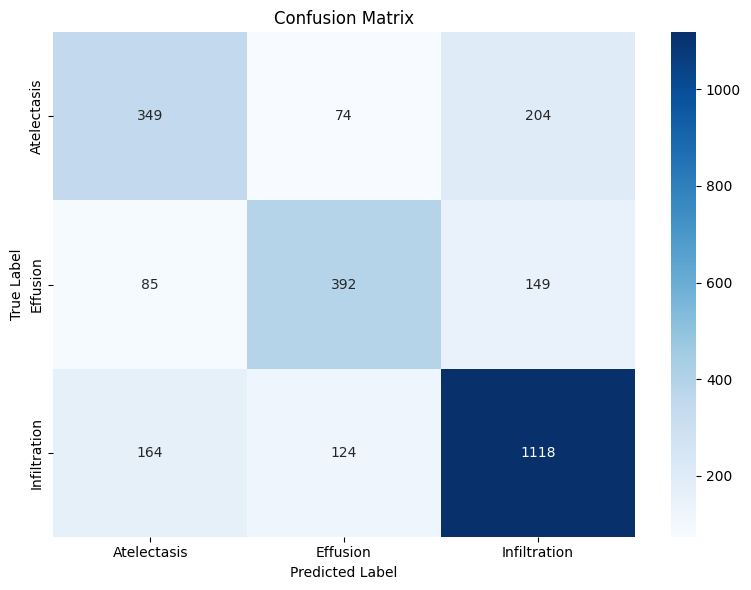

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import efficientnet_b0
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# model: efficientnet b0
num_classes = len(dataset.class_names)
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop setup
epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
patience = 3
counter = 0



# training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # early stopping when val_loss increases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

# plot loss and accuracy
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


model.load_state_dict(torch.load("best_model.pth"))

# eval on test set
model.eval()
test_loss = 0.0
test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)

        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_acc = test_correct / len(test_loader.dataset)

print(f"\n✅ Final Test Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")

# classification report for f1
print("\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_names))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.class_names,
            yticklabels=dataset.class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
